### Discription:
This notebook demonstrates an end-to-end image classification pipeline using a Convolutional Neural Network on the Dogs vs Cats dataset. The implementation follows concepts from Deep Learning with Python and serves as a practical exercise in building, training, and evaluating deep learning models.

## About the dataset:
* All the pictures in the dataset are JPEGs. 
* This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed).

## Approach we'll be following:
* We'll create a new dataset completely contining three parts:
1. Training set: 1000 samples from each dog and cat class
2. Validation set: 500 samples from each class again
3. Test set: 1000 samples from each class

Why not use the whole training data: As its my learning phase and im sure that im not alone in the learning phase, so in real world many of the image datasets would only contain a few thousand images, so its a good practice to learn with small datasets.

## Froming different subsets of our data:

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 0 = hide all, 1 = hide INFO, 2 = hide WARNING, 3 = hide ERROR
#The above piece of code is to hide the warnings 

In [2]:
import os, shutil, pathlib

orignal_directory_path = '/kaggle/input/dogs-vs-cats/train'
orignal_directory = pathlib.Path(orignal_directory_path) #existing training data
new_base_directory = pathlib.Path('cats_vs_dogs_subset') #new directory for our subset

In [3]:
def make_subset(subset_name,start_index,end_index):
    for category in ['cat','dog']:
        dir = new_base_directory / subset_name / category
        os.makedirs(dir)
        file_names = [f'{category}.{i}.jpg'
                     for i in range(start_index,end_index)]
        for fname in file_names:
            shutil.copyfile(src= orignal_directory / fname,
                           dst= dir / fname)

make_subset('train', start_index=0, end_index=1000)
make_subset('validation', start_index=1000, end_index=1500)
make_subset('test', start_index=1500, end_index=2500)

We now have 3 subsets of the data to train, validate and run tests on. Each split/subset is a balanced one since they all contain equal number of samples from each class(i.e. Dog and Cat), it bascically becomes a binary_classification problem which makes accuracy as a good metrics to evaluate on. 

## Building the model:
This convnet model will be a stack of alternately placed Conv2D(with activation='relu') and MaxPooling layers.
We'll start from inputs of size 180 pixels x 180 pixels, and will end up with feature maps of size 7x7 just before the Flatten layer.

Since its a binary classification problem the last layer will be a dense layer with 1 unit and sigmoid activation.

We will start the model with a Rescaling layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range. Why?? Its simple just as a grayscale images pixal is a number between 0-255 similarly in RGB images the pixal is [0-255,0-255,0-255] so 1/255 * pixal --> [0-1,0-1,0-1]. 

What are the benifits of this rescaling???
### Benefits of rescaling:
* Gradient descent works much better when inputs are normalized. The model reaches good performance in fewer epochs.
* Neural networks use many multiplications and activations. Smaller numbers = less risk of exploding values.

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180,180,3), name='input_layer') #RGB images of size 180x180
x = layers.Rescaling(1./255, name='rescaling_layer') (inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='convolution_layer_1') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_1') (x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='convolution_layer_2') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_2') (x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='convolution_layer_3') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_3') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_4') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_4') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_5') (x)
x = layers.Flatten() (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs=inputs, outputs=outputs, name='classifier_convnet_1')

2026-02-10 14:21:34.433832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770733294.591449      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770733294.633370      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770733294.990947      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770733294.990993      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770733294.990996      55 computation_placer.cc:177] computation placer alr

In [5]:
model.summary()

Model: "classifier_convnet_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_layer (Rescaling)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_1 (Conv2D)    │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_1 (MaxPooling2D)     │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_2 (Conv2D)    │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_2 (MaxPooling2D)     │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_3 (Conv2D)    │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_3 (MaxPooling2D)     │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_4 (Conv2D)    │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling_4 (MaxPooling2D)     │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convolution_layer_5 (Conv2D)    │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model: 

In [6]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Data Preprocesssing:
Right now the data is in our directory in form of JPEGs so we'll need to:
*  Decode the JPEG content to RGB grids of pixals.
*  Convert these into floating-point tensors.
*  Resize them to a shared size of 180x180 which is input shape of our model.
*  Pack them into batches(here batch_size will be 32)

Keras features the utility function 
*image_dataset_from_directory()*
, which lets us quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors.

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_directory / 'train',
    image_size=(180,180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_directory / 'validation',
    image_size=(180,180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_directory / 'test',
    image_size=(180,180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


The output of teh above piece of code are Dataset objects, it yields batches of 180  180
RGB images (shape (32, 180, 180, 3)) and integer labels (shape (32,)). There are
32 samples in each batch (the batch size).

In [8]:
for data_batch, labels_batch in train_dataset:     
    print("data batch shape:", data_batch.shape)     
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


## Fitting the data to the model:
We'll also pass *validation_data* argument in the **fit()** method to keep track of validation metrics.

Also using **ModelCheckpoint** callback to save the model after each epoch. Arguments *save_best_only=True* and *monitor="val_loss"* will also be passed they tell the callback to
only save a new file (overwriting any previous one) when the current value of the
val_loss metric is lower than at any previous time during training. 
As a result, we won’t have to retrain a new model for a lower number of epochs if we start
overfitting: we can just reload our saved file.

In [9]:
#Defining teh callback
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "best_convnet_classifer_so_far.keras",
        save_best_only = True,
        monitor = 'val_loss')
]

#fitting data to the model
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data = validation_dataset,
    callbacks = callbacks)

Epoch 1/30


I0000 00:00:1770733310.871921     119 service.cc:152] XLA service 0x7cca34089ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770733310.871978     119 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1770733311.235205     119 cuda_dnn.cc:529] Loaded cuDNN version 91002


 5/63 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3830 - loss: 0.8338

I0000 00:00:1770733314.944972     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - accuracy: 0.4907 - loss: 0.7256 - val_accuracy: 0.5000 - val_loss: 0.6977
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5342 - loss: 0.6952 - val_accuracy: 0.5540 - val_loss: 0.6823
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5785 - loss: 0.6804 - val_accuracy: 0.5550 - val_loss: 0.6803
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6266 - loss: 0.6516 - val_accuracy: 0.6160 - val_loss: 0.6408
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6449 - loss: 0.6336 - val_accuracy: 0.6180 - val_loss: 0.6540
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6850 - loss: 0.5806 - val_accuracy: 0.6050 - val_loss: 0.6797
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7197 - loss: 0.5432 - val_accuracy: 0.6970 - val_loss: 0.5758
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7448 - loss: 0.5301 - val_accuracy: 0.7110 - val_loss: 

## Plotting the loss and accuracy:

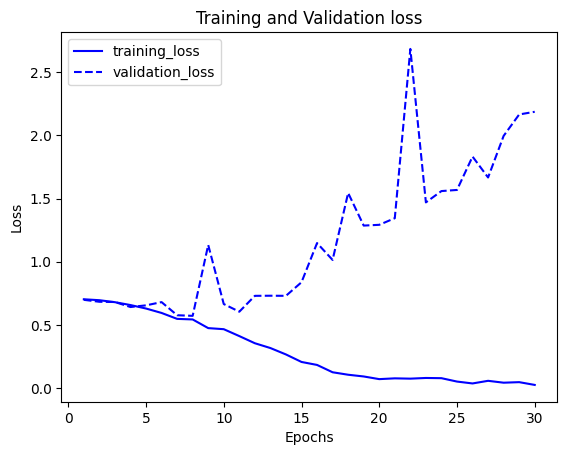

In [10]:
import matplotlib.pyplot as plt

# training_loss and val_loss on each epoch 
epochs = 30
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

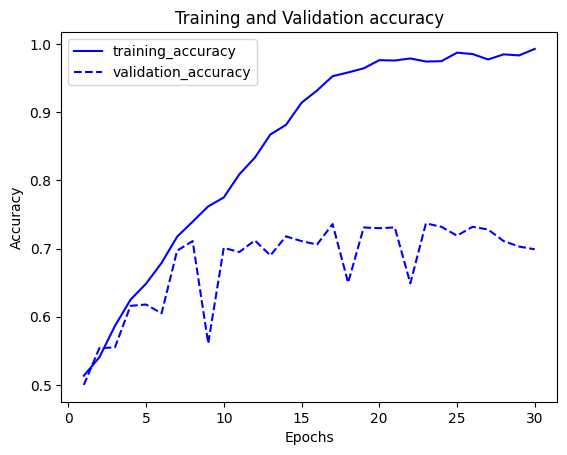

In [11]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

The above graphs showcase clear overfitting. Where training accuracy reaches 100% eventually and validation_accuracy peaks at approx 75%. Similarly validation loss reaches its lowest at epoch=10 thereafter it keeps on increasing while the training loss keeps decreasing.

## Evaluating the saved best model on test set:

In [12]:
test_model = keras.models.load_model('best_convnet_classifer_so_far.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7186 - loss: 0.5889
Test accuracy: 0.707


Test accuracy achived is in range 65-70% 

## Using Data Augmentation:
Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable-looking images.The goal is that, at training time, our model will never see the exact same picture twice. This helps expose the model
to more aspects of the data so it can generalize better.

### Defining a data augmentation stage/layer to add to our model:

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'), #Applies horizontal flipping to a random 50% of the images that go through it
        layers.RandomRotation(0.1), #Rotates the input images by a random value in the range [–10%, +10%]
        layers.RandomZoom(0.2), #Zooms in or out of the image by a random factor in the range [-20%, +20%]
    ]
)

For curious people who are wondering how augmentation acctually works heres a practical example:

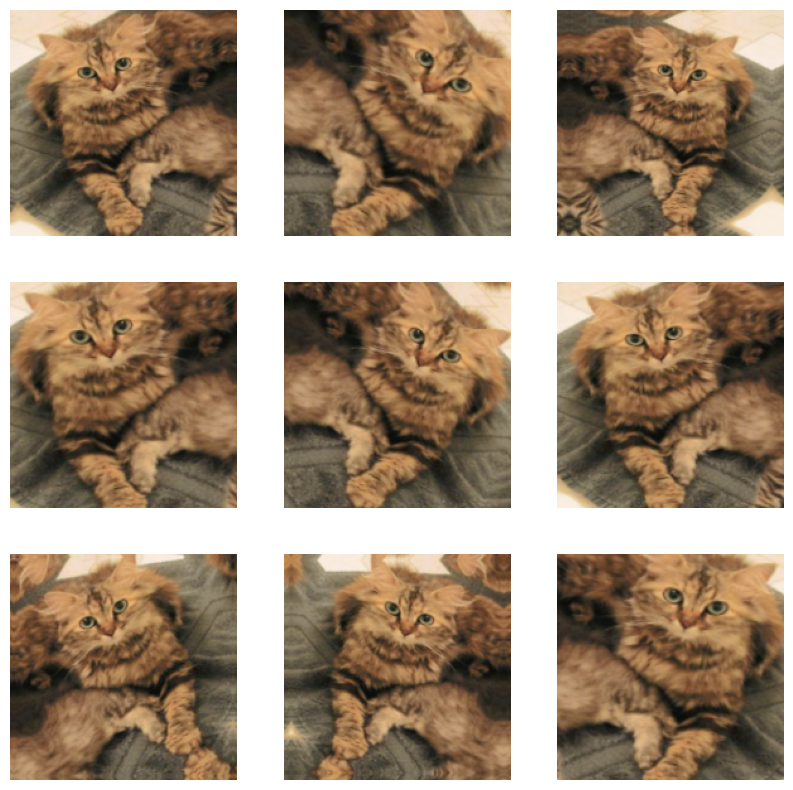

In [14]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(3):  #We can use take(N) to only sample N batches from the dataset. 
    for i in range(9):
        augmented_images = data_augmentation(images) #Apply augmentation stage to the batch of images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8")) #Display the first image in the output batch.For each of the nine iterations, this is a different augmentation of the same image.  
        plt.axis("off")

If we train a new model using this data-augmentation configuration, the model will
never see the same input twice. But the inputs it sees are still heavily intercorrelated
because they come from a small number of original images—we can’t produce new
information; we can only remix existing information.

The augmentation wont completely get rid of overfitting so we'll also add a dropout layer right before the final output layer.

Just like Dropout, data augmentation layers are also inactive during inference (when we call predict() or evaluate()). That is during evaluation, our model will behave just the same as when it did not include data augmentation and dropout.

## Forming a new ConvNet:

In [15]:
inputs = keras.Input(shape=(180,180,3,), name='input_layer')
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name='rescaling_layer') (inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu', name='convolution_layer_1') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_1') (x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', name='convolution_layer_2') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_2') (x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', name='convolution_layer_3') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_3') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_4') (x)
x = layers.MaxPooling2D(pool_size=2, name='MaxPooling_4') (x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu', name='convolution_layer_5') (x)
x = layers.Flatten() (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs=inputs, outputs=outputs, name='classifier_convnet_2')

In [16]:
#compiling the new model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Training new model on training dataset:

In [17]:
#setting callbacks as last time
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_convnet_classifier_with_augmentation.keras',
        save_best_only=True,
        monitor='val_loss')
]

#tracking loss and metrics
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.5041 - loss: 0.7177 - val_accuracy: 0.5070 - val_loss: 0.6921
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5162 - loss: 0.6943 - val_accuracy: 0.5010 - val_loss: 0.6889
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5571 - loss: 0.6852 - val_accuracy: 0.6050 - val_loss: 0.6670
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5989 - loss: 0.6694 - val_accuracy: 0.5530 - val_loss: 0.6955
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6213 - loss: 0.6531 - val_accuracy: 0.6320 - val_loss: 0.6395
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6662 - loss: 0.6201 - val_accuracy: 0.6720 - val_loss: 0.5928
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7174 - loss: 0.5809 - val_accuracy: 0.5670 - val_loss: 1.2802
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7237 - loss: 0.5646 - val_accuracy: 0.

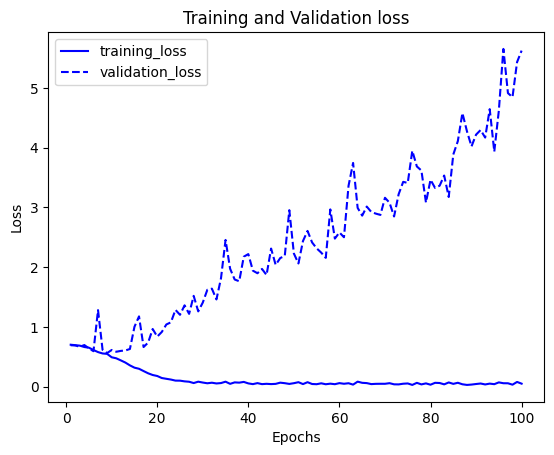

In [18]:
# training_loss and val_loss on each epoch 
epochs = 100
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

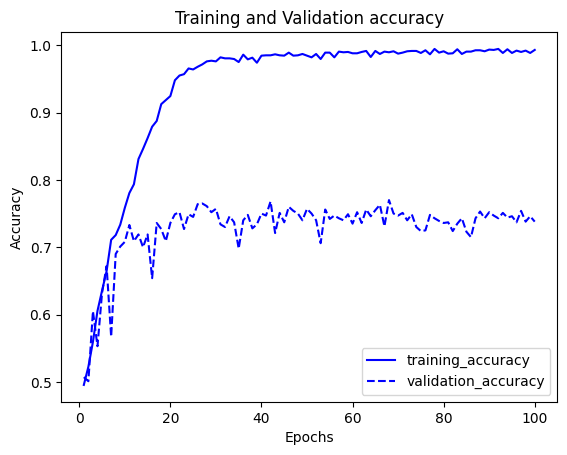

In [19]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

As can be seen the validation accuracy range increased to around 77%-80%.

## Evaluating on test dataset:

In [20]:
best_model = keras.models.load_model('best_convnet_classifier_with_augmentation.keras')
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"test_accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7046 - loss: 0.5728
test_accuracy: 0.708


Although the model successfully implemented the complete image classification pipeline, its performance leaves room for improvement, highlighting the need for better architecture design, data augmentation, and transfer learning techniques to achieve higher accuracy and stronger generalization.

## Leveraging a pretrained model:
Using a pretrained model is highlt effective approach in deep learning. A pretrained model is a model that was previously trained on
a large dataset, typically on a large-scale image-classification task.

We’ll use the VGG16 architecture because its architecture is similar to what we're already familiar with, and it’s easy to understand without
any new concepts required to be learnt.

There are two ways to use a pretrained model: feature extraction and fine-tuning, this notebook will cover both.

## Feature extraction:
Feature extraction consists of using the representations learned by the previously trained model to extract deatures frm new samples. These features are then passed into a new clasifier, which is trained from scratch.

Convnets have two parts a series of pooling and convolution layers, and 2nd part is the output_layer whichis a densly connected classifier layer.
The first part is known as **convolutional base** of the model. In convnets feature extraction consists of taking this convolutional base of a pretrained model and running new data through it and training a new classifier on top of the output.

The VGG16 model, among others, comes prepackaged with Keras. We can import it from the keras.applications module.

### Instatiating the VGG16 convolutional base:

In [21]:
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',  
    include_top=False, #refers to including or not including the densly connected classifier layer at the end of the model
    input_shape=(180,180,3)) #shape of the image tensors that we’ll feed to the network.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

The final feature map has shape (5, 5, 512). That’s the feature map on top of which we’ll stick a densely connected classifier.

## Preparing final model with convolutional base:
We will first freeze the convolutional base. Freezing a layer or set of
layers means preventing their weights from being updated during training. If we don’t
do this, the representations that were previously learned by the convolutional base will
be modified during training.

 In Keras, we freeze a layer or model by setting its *trainable* attribute to *False*.

In [24]:
conv_base.trainable = True
print("This is the number of trainable weights " 
"before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [25]:
conv_base.trainable = False
print("This is the number of trainable weights " 
"after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


New model architecture will be as follows:
* Data augmentation stage
* Frozen convolutional base stage
* Dense classifier/ Classification stage

In [28]:
#defining data augmentation layer:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

In [31]:
#Defining model
inputs = keras.Input(shape=(180,180,3), name='Input_layer')
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x) # VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.
x = conv_base(x)
x = layers.Flatten() (x)
x = layers.Dense(256) (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(1, activation='sigmoid', name='output_layer') (x)

model = keras.Model(inputs,outputs)

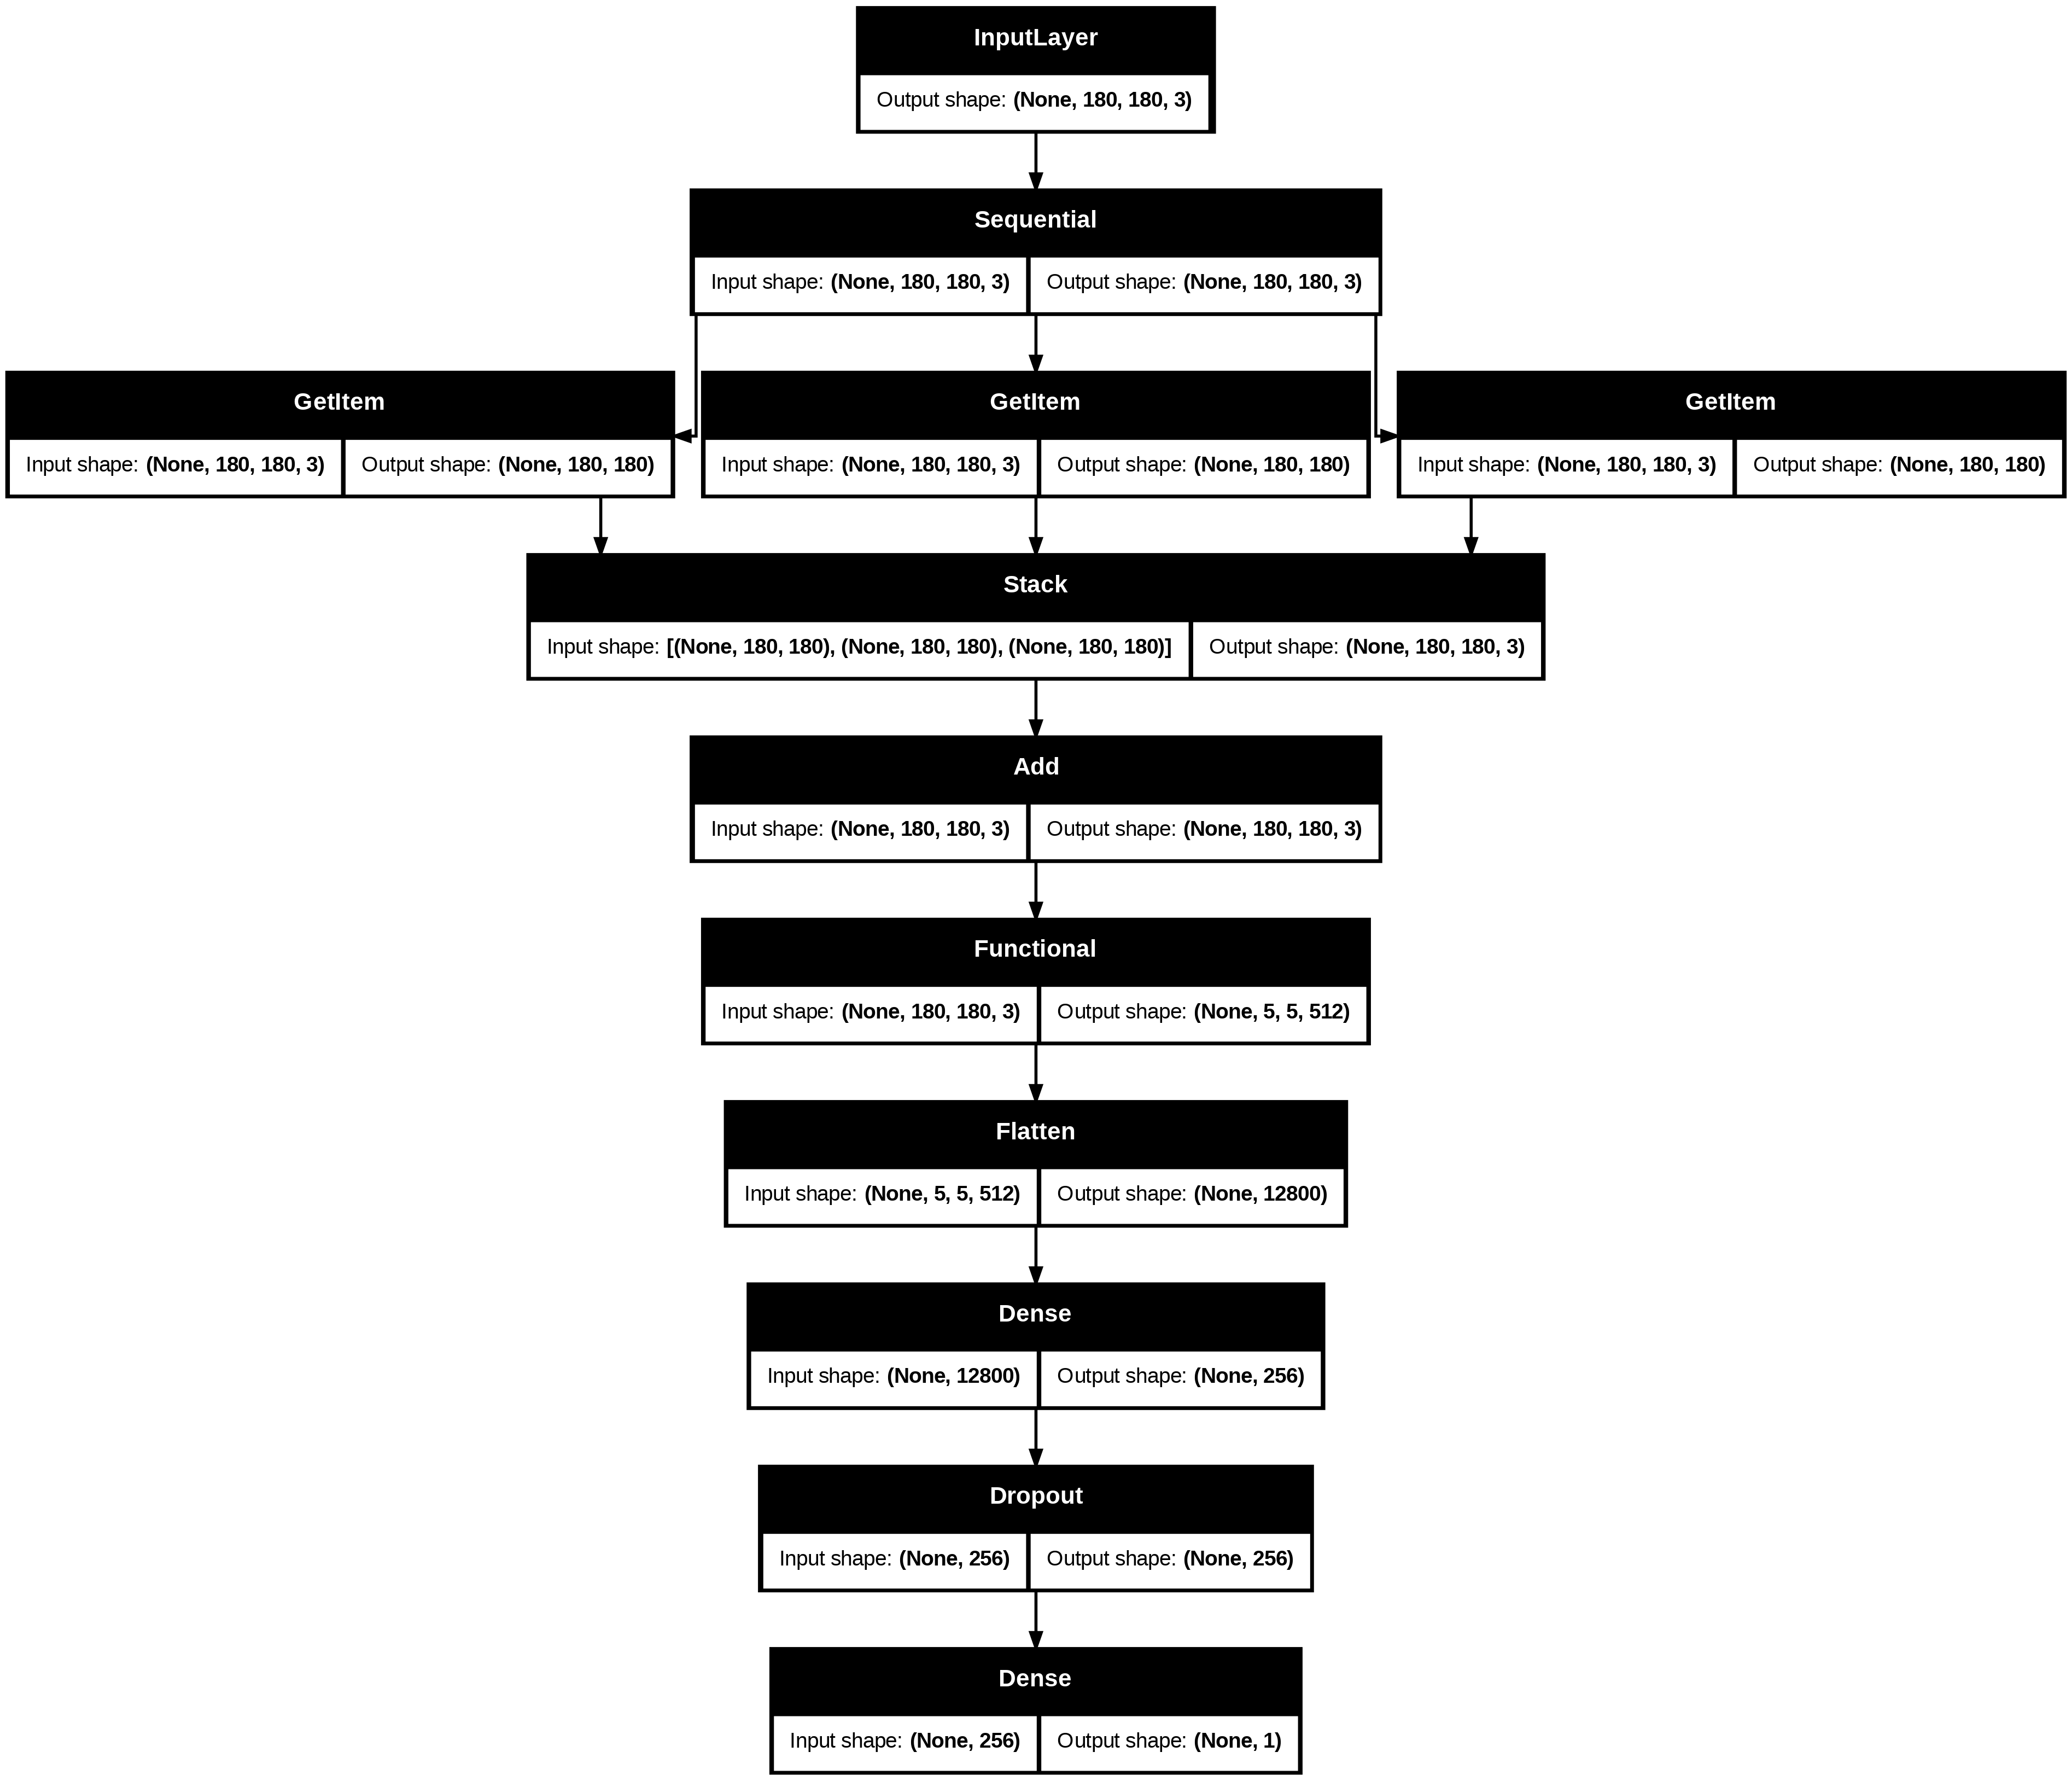

In [33]:
keras.utils.plot_model(model, show_shapes=True) #the final argument rankdir = 'LR' plots the model horizontally

In [35]:
#compiling the model
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

With this setup, only the weights from the two Dense layers that we added will be trained.

In [37]:
#setting a callback to save model at checkpoint before fitting the data to it
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'best_feature_exraction_model_so_far.keras',
        save_best_only = True,
        monitor = 'val_loss')
]

In [38]:
#fitting the dataset to the model
history = model.fit(
    train_dataset,
    callbacks=callbacks,
    epochs=50,
    validation_data=validation_dataset)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.8261 - loss: 26.0261 - val_accuracy: 0.9660 - val_loss: 4.4747
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9458 - loss: 7.5897 - val_accuracy: 0.9630 - val_loss: 7.8858
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9482 - loss: 7.7674 - val_accuracy: 0.9790 - val_loss: 4.7812
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9553 - loss: 5.4709 - val_accuracy: 0.9800 - val_loss: 3.6805
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9579 - loss: 5.1923 - val_accuracy: 0.9860 - val_loss: 2.9948
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9706 - loss: 3.0309 - val_accuracy: 0.9760 - val_loss: 4.0854
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.9676 - loss: 4.9849 - val_accuracy: 0.9800 - val_loss: 3.5259
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9643 - loss: 4.7505 - val_accuracy: 0.9830 

## Plotting the results on validation dataset:

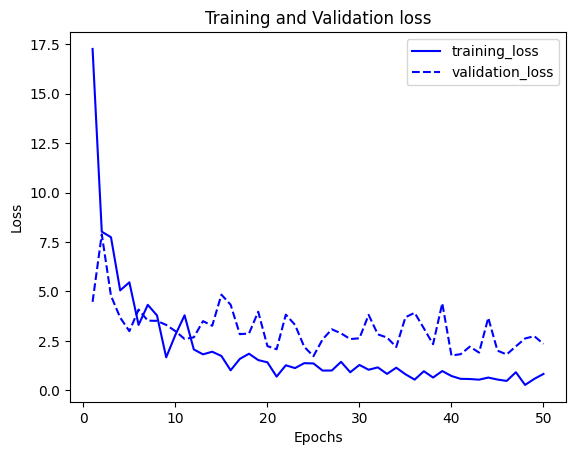

In [39]:
# training_loss and val_loss on each epoch 
epochs = 50
training_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1,epochs+1), training_loss, 'b-', label='training_loss')
plt.plot(range(1,epochs+1), val_loss, 'b--', label='validation_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation loss')
plt.show()

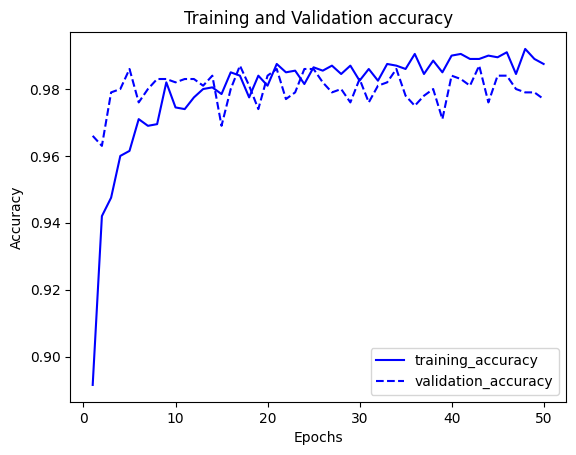

In [40]:
#plotting training_accuracy and validation_accuracy

training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1,epochs+1), training_acc, 'b-', label='training_accuracy')
plt.plot(range(1,epochs+1), val_acc, 'b--', label='validation_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

## Evaluating the selected best model on test set:

In [42]:
#Retriving the best model
best_model = keras.models.load_model('best_feature_exraction_model_so_far.keras')

In [43]:
#predicting
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Accuracy on test set was: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9756 - loss: 4.1888
Accuracy on test set was: 0.977


There was a huge change in the test set accuracy from our only data_augmentation model, the reason being that the VGG16 model is a pretrained model on the 'ImageNet' dataset which consists of around ~1.43 million samples and 1000 classes and some of thoes calsses are cats and dogs so the pretrained model had already learnt strong(since the ImageNet dataset is huge) weights for cats and dogs that we reused by freezig them(not letting them update according to our dataset).

The model can further be enhanced to achive even greater accuracy via Fine-tuning the pretrained model...

## Fine-tuning the pretrained model:
Fine-tuning consists of unfreezing a few of the lower layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these lower layers.

It’s only possible to fine-tune the lower layers of the convolutional base once the classifier_layer has already been trained.If the classifier isn’t
already trained, the error signal propagating through the network during training will be too large, and the representations previously learned by
the layers being fine-tuned will be destroyed.

Steps for fine-tuning a pretrained model are as follows:
1. Add our custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part we added. (Till this step we are already done as seen above)
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part we added.

In [44]:
#For referance
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

We’ll fine-tune the last three convolutional layers and the last pooling layer as well.
Why do we not fine-tune more layers of the model??
Thats because earlier layers in the convolutional base encode more generic, reusable features, whereas layers by the end encode more specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed on our new problem.

## Setting up the fine-tuning setup:

In [45]:
# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now the fine-tuning can begin

## Fine-tuning the model:

In [46]:
model.compile(loss="binary_crossentropy",
      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), #The reason for using low learning rate is we want to limit the magnitude of modifications made on the representations of the layers we are fine-tuning
      metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
filepath="fine_tuning.keras",
save_best_only=True,
monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9867 - loss: 0.7659 - val_accuracy: 0.9770 - val_loss: 2.2546
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9885 - loss: 0.6038 - val_accuracy: 0.9800 - val_loss: 2.0060
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9875 - loss: 1.0089 - val_accuracy: 0.9810 - val_loss: 1.7697
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9912 - loss: 0.3367 - val_accuracy: 0.9820 - val_loss: 1.8282
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9890 - loss: 0.3568 - val_accuracy: 0.9780 - val_loss: 2.0663
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.9906 - loss: 0.7655 - val_accuracy: 0.9800 - val_loss: 1.6385
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9949 - loss: 0.1970 - val_accuracy: 0.9830 - val_loss: 1.8424
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9936 - loss: 0.2819 - val_accuracy: 0.9810 - v

## Final Testing:

In [47]:
best_model = keras.models.load_model('fine_tuning.keras')
test_loss, test_acc = model.evaluate(test_dataset) 
print(f"Final Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9711 - loss: 3.2064
Final Test accuracy: 0.973


Though the validation accuracy was greater than the previous without fine tuning model there wasn't much chnage in the final test set accuracy, the reason could be the samples in the test data being difficult to interpret thats the only explaination I could think of. Results might differ by little here and there if you run the notebook on your end due to randomness in the networks. 

## Key Takeaways:
* Proper data preprocessing and normalization are essential for effective CNN training.
* image_dataset_from_directory simplifies loading and batching image datasets.
* CNNs automatically learn hierarchical visual features, making them ideal for image classification.
* Training vs validation curves help identify overfitting and generalization issues.
* Small datasets often require techniques like augmentation, dropout, and regularization for better performance.
* Deep learning is an iterative process of build → train → evaluate → improve.